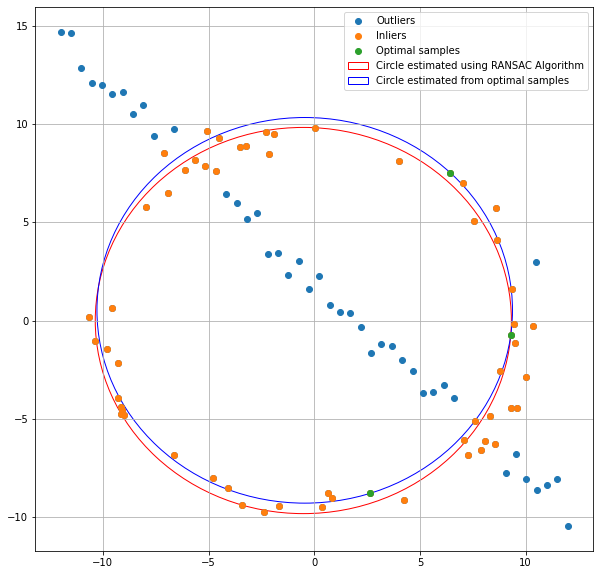

In [15]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import inv
import matplotlib.pyplot as plt
#np.random.seed(0)
N = 100
half_n = N//2
r = 10
s = r/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)
x ,y = (r + n)*np.cos(t), (r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))




from matplotlib.patches import Circle

#Function to get n random points from data
def RandomPoints(data, n):
    point_list = []
    count = 0
    
    while count < n:
        index = np.random.randint(len(data))
        x = data[index][0]
        y = data[index][1]

        if (x, y) not in point_list:
            point_list.append((x, y))
            count += 1

    return point_list


#Function to get circle parameters from sample
def CircData(data):    
    pt1 = data[0]
    pt2 = data[1]
    pt3 = data[2]

    A = np.array([[pt2[0] - pt1[0], pt2[1] - pt1[1]], [pt3[0] - pt2[0], pt3[1] - pt2[1]]]) 
    B = np.array([[pt2[0]**2 - pt1[0]**2 + pt2[1]**2 - pt1[1]**2], [pt3[0]**2 - pt2[0]**2 + pt3[1]**2 - pt2[1]**2]])		
    A_inv = inv(A)

    p, q = np.dot(A_inv, B) / 2
    p, q = p[0], q[0]
    r = np.sqrt((p - pt1[0])**2 + (q - pt1[1])**2)

    return (p, q, r)


def InliersAndDistance(circ, data, thres):
    distance = 0
    inliers = []

    x_data = data[:, 0]
    y_data = data[:, 1]

    p = circ[0]
    q = circ[1]
    r = circ[2]

    for i in range(len(x_data)):
        dis = np.sqrt((x_data[i] - p)**2 + (y_data[i] - q)**2)

        if abs(dis - r) <= thres:
            inliers.append([x_data[i], y_data[i]])
            distance += abs(dis - r)
    
    return inliers, distance


fig, ax = plt.subplots(figsize=(10,10))
ax.plot(X[:,0], X[:, 1], 'o', label='Outliers')
ax.grid(True)

x_data = X[:, 0]
y_data = X[:, 1]
repititions = 35
thres_inlier = r/8
thres_inlier_count = 50
optimal_model = [0, 0, 999999, []]

for i in range(repititions):
    sample = RandomPoints(X, 3)
    init_circ = CircData(sample)

    if abs(r - init_circ[2]) > 1.5*r:
        continue
    
    inliers, distance = InliersAndDistance(init_circ, X, thres_inlier)
    
    if len(inliers) < thres_inlier_count:
        continue

    inlier_sample = RandomPoints(inliers, 3)

    circ = CircData(inlier_sample)

    inliers, distance = InliersAndDistance(circ, X, thres_inlier)

    if len(inliers) < thres_inlier_count:
        continue

    if len(optimal_model[-1]) < len(inliers):
        optimal_model = [circ, init_circ, sample, distance, inliers]
    elif len(optimal_model[-1]) == len(inliers):
        if optimal_model[3] > distance:
            optimal_model = [circ, init_circ, sample, distance, inliers]

if len(optimal_model[-1]) == 0:
    print("Cannot Find Best Model")

else:
    inliers = np.array(optimal_model[-1])
    ax.plot(inliers[:, 0], inliers[:, 1], 'o', label='Inliers')

    optimal_samples = np.array(optimal_model[2])
    ax.plot(optimal_samples[:,0], optimal_samples[:, 1], 'o', label='Optimal samples')

    p, q, r = optimal_model[0][0], optimal_model[0][1], optimal_model[0][2]
    circ = Circle((p, q), r, color = 'r', fc = 'y', fill = False, label = 'Circle estimated using RANSAC Algorithm')
    ax.add_patch(circ)

    p, q, r = optimal_model[1][0], optimal_model[1][1], optimal_model[1][2]
    esti_circ = Circle((p, q), r, color = 'b', fc = 'y', fill = False, label = 'Circle estimated from optimal samples')
    ax.add_patch(esti_circ)

ax.legend()